In [3]:
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import trange
import seaborn as sns
import numpy as np

import os
os.environ["KMP_DUPLICATE_LIB_OK"]='TRUE'

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Load Minst Dataset

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
train_loader = DataLoader(datasets.MNIST(root="./data", train=True, download=True, transform=transform), batch_size=128, shuffle=True)


## Cosine Schedule

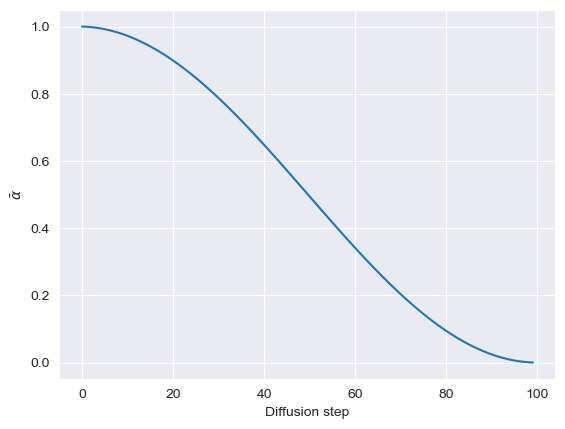

In [6]:
diffusion_steps = 100
s = 0.008
timesteps = torch.arange(0, diffusion_steps, dtype=torch.float32)
schedule = torch.cos((timesteps / diffusion_steps + s) / (1 + s) * torch.pi / 2) ** 2
baralphas = schedule / schedule[0]
betas = 1 - baralphas / torch.cat([baralphas[:1], baralphas[:-1]])
alphas = 1 - betas

sns.lineplot(baralphas)
plt.xlabel("Diffusion step")
plt.ylabel(r"$\bar{\alpha}$")
plt.show()

baralphas = baralphas.to(device)

In [7]:
def q_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    sqrt_alphas_cumprod = baralphas[t].sqrt().view(-1, 1, 1, 1).to(device)
    sqrt_one_minus_alphas = (1 - baralphas[t]).sqrt().view(-1, 1, 1, 1).to(device)
    return sqrt_alphas_cumprod * x0 + sqrt_one_minus_alphas * noise, noise

## Demonstrate the effect of adding noise to the same image at multiple diffusion time steps.

In [8]:
def plot_diffusion_steps(x0, steps=[0, 10, 50, 99], cmap="gray"):
    x0 = x0.to(device)
    fig, axes = plt.subplots(1, len(steps), figsize=(15, 3))

    for i, t_step in enumerate(steps):
        t = torch.tensor([t_step], device=device)
        xt, _ = q_sample(x0, t)
        img = xt.squeeze().cpu().detach().numpy()

        axes[i].imshow(img, cmap=cmap)
        axes[i].set_title(f"t = {t_step}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

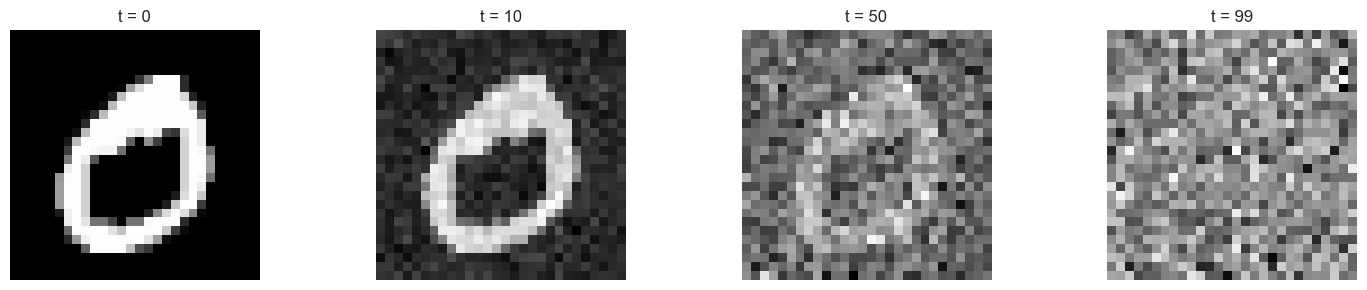

In [9]:
x_test, _ = next(iter(train_loader))
x0 = x_test[0:1]  # shape: [1, 1, 28, 28]

plot_diffusion_steps(x0, steps=[0, 10, 50, 99])


### Display the original image and the corresponding noise-added image overlaid at each time step.

In [10]:
def plot_mnist_noised_overlay(x0, steps=[0, 10, 50, 99]):
    x0 = x0.to(device)
    fig, axes = plt.subplots(1, len(steps), figsize=(3 * len(steps), 3))

    for i, t_step in enumerate(steps):
        t = torch.tensor([t_step], device=device)
        xt, _ = q_sample(x0, t)

        # 原图和加噪图 → [28, 28]
        x0_img = x0.squeeze().cpu().detach().numpy()
        xt_img = xt.squeeze().cpu().detach().numpy()

        # 创建重叠图像：原图用灰度，噪声用伪彩色红色通道（简单高亮）
        overlay = np.stack([xt_img, x0_img, x0_img], axis=-1)  # R,G,B
        overlay = np.clip(overlay, 0, 1)

        axes[i].imshow(overlay, interpolation='nearest')
        axes[i].set_title(f"t = {t_step}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()


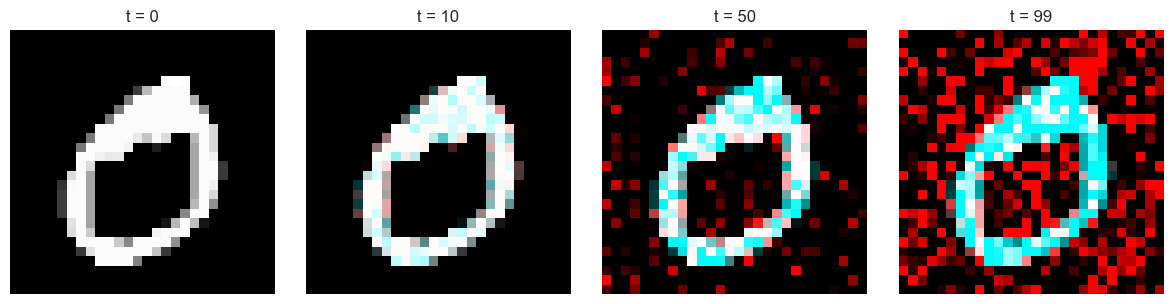

In [11]:
# x_test, _ = next(iter(train_loader))
# x0 = x_test[0:1]  # shape: [1, 1, 28, 28]

plot_mnist_noised_overlay(x0, steps=[0, 10, 50, 99])


## Define a CNN model to predict the noise at each diffusion time step.

In [38]:
# class MNISTDiffusionCNN(nn.Module):
#     def __init__(self, dropout_prob=0.1):
#         super().__init__()
#         self.conv1 = nn.Conv2d(2, 32, 3, padding=1)
#         self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
#         self.dropout = nn.Dropout2d(dropout_prob)
#         self.conv3 = nn.Conv2d(64, 1, 3, padding=1)
#
#     def forward(self, x: torch.Tensor, t: torch.Tensor):
#         t_embed = t[:, None, None, None].float() / diffusion_steps
#         t_embed = t_embed.expand(-1, 1, 28, 28).to(x.device)
#
#         xt = torch.cat([x, t_embed], dim=1)
#
#         out = F.relu(self.conv1(xt))
#         out = F.relu(self.conv2(out))
#         out = self.dropout(out)
#         out = self.conv3(out)
#         return out


class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_prob=0.1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(dropout_prob)
        )

    def forward(self, x):
        return self.block(x)

class Down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.pool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_ch, out_ch)
        )

    def forward(self, x):
        return self.pool_conv(x)

class Up(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, in_ch // 2, 2, stride=2)
        self.conv = ConvBlock(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # 对齐大小（必要时）
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class MNISTUNet(nn.Module):
    def __init__(self, time_dim=1):
        super().__init__()
        self.inc = ConvBlock(1 + time_dim, 32)  # 加时间通道
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.up1 = Up(128, 64)
        self.up2 = Up(64, 32)
        self.outc = nn.Conv2d(32, 1, kernel_size=1)

    def forward(self, x, t):
        # 时间嵌入广播
        t_embed = t[:, None, None, None].float() / diffusion_steps
        t_embed = t_embed.expand(-1, 1, 28, 28).to(x.device)
        xt = torch.cat([x, t_embed], dim=1)

        x1 = self.inc(xt)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x = self.up1(x3, x2)
        x = self.up2(x, x1)
        return self.outc(x)

## Monte Carlo Dropout

In [39]:
# model = MNISTDiffusionCNN().to(device)
model = MNISTUNet().to(device)

In [40]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [41]:
epochs = 10
model.train()
for epoch in range(epochs):
    total_loss = 0
    for x, _ in train_loader:
        x = x.to(device)
        t = torch.randint(0, diffusion_steps, (x.size(0),), device=device)
        noised_x, noise = q_sample(x, t)
        pred_noise = model(noised_x, t)
        loss = loss_fn(pred_noise, noise)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}, Loss: {total_loss / len(train_loader):.4f}")


Epoch 0, Loss: 0.1711
Epoch 1, Loss: 0.0881
Epoch 2, Loss: 0.0796
Epoch 3, Loss: 0.0760
Epoch 4, Loss: 0.0735
Epoch 5, Loss: 0.0715
Epoch 6, Loss: 0.0695
Epoch 7, Loss: 0.0685
Epoch 8, Loss: 0.0672
Epoch 9, Loss: 0.0675


### Predict the noise at t=50 for the first 16 images in the test set.

In [42]:
def predict_with_uncertainty(model, x, t, n_samples=50):
    model.train()  # 开启 Dropout
    preds = torch.stack([model(x, t) for _ in range(n_samples)])
    mean = preds.mean(0)
    std = preds.std(0)
    return mean, std

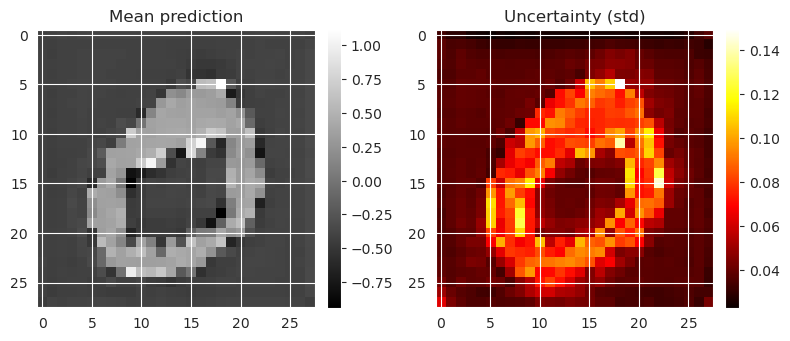

In [43]:
# x_test, _ = next(iter(train_loader))
x_test = x_test[:16].to(device)
t_test = torch.full((x_test.size(0),), 50, device=device)
mc_mean_pred, mc_std_pred = predict_with_uncertainty(model, x_test, t_test)
# print(mean_pred)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

image0 = axes[0].imshow(mc_mean_pred[0].squeeze().cpu().detach(), cmap="gray")
axes[0].set_title("Mean prediction")
plt.colorbar(image0, ax=axes[0], fraction=0.046, pad=0.04)

image1 = axes[1].imshow(mc_std_pred[0].squeeze().cpu().detach(), cmap="hot")
axes[1].set_title("Uncertainty (std)")
plt.colorbar(image1, ax=axes[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

In [44]:
def analyze_uncertainty(std_pred: torch.Tensor, mean_pred: torch.Tensor = None, threshold: float = 0.1):
    results = {}

    flat_std = std_pred.view(-1)

    results["uncertainty_mean"] = float(flat_std.mean())
    results["uncertainty_std"] = float(flat_std.std())
    results["uncertainty_max"] = float(flat_std.max())
    results["uncertainty_min"] = float(flat_std.min())
    results["high_uncertainty_ratio"] = float((flat_std > threshold).float().mean())

    return results

In [45]:
metrics = analyze_uncertainty(mc_std_pred, mean_pred=mc_mean_pred)

for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

uncertainty_mean: 0.0491
uncertainty_std: 0.0219
uncertainty_max: 0.2060
uncertainty_min: 0.0212
high_uncertainty_ratio: 0.0490


## Display the original image, the true noise, and the predicted noise at t=50.

In [46]:
def plot_predicted_vs_true_noise(model, x0, t_step=50):
    model.eval()
    x0 = x0.to(device)
    t = torch.tensor([t_step], device=device)

    # 加噪，获取真实噪声
    x_t, true_noise = q_sample(x0, t)

    # 模型预测噪声
    with torch.no_grad():
        pred_noise = model(x_t, t)

    mse = F.mse_loss(pred_noise, true_noise).item()
    print(f"MSE between predicted and true noise: {mse:.6f}")

    # 转为 NumPy 格式
    x0_img = x0.squeeze().cpu().numpy()
    true_noise_img = true_noise.squeeze().cpu().numpy()
    pred_noise_img = pred_noise.squeeze().cpu().numpy()

    # 绘图
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    cmap = "gray"

    axes[0].imshow(x0_img, cmap=cmap)
    axes[0].set_title("Original Image x₀")
    axes[0].axis("off")

    axes[1].imshow(true_noise_img, cmap="seismic", vmin=-1, vmax=1)
    axes[1].set_title(f"True Noise (t={t_step})")
    axes[1].axis("off")

    axes[2].imshow(pred_noise_img, cmap="seismic", vmin=-1, vmax=1)
    axes[2].set_title("Predicted Noise")
    axes[2].axis("off")

    plt.tight_layout()
    plt.rcParams['font.family'] = 'DejaVu Sans'
    plt.show()

MSE between predicted and true noise: 0.047315


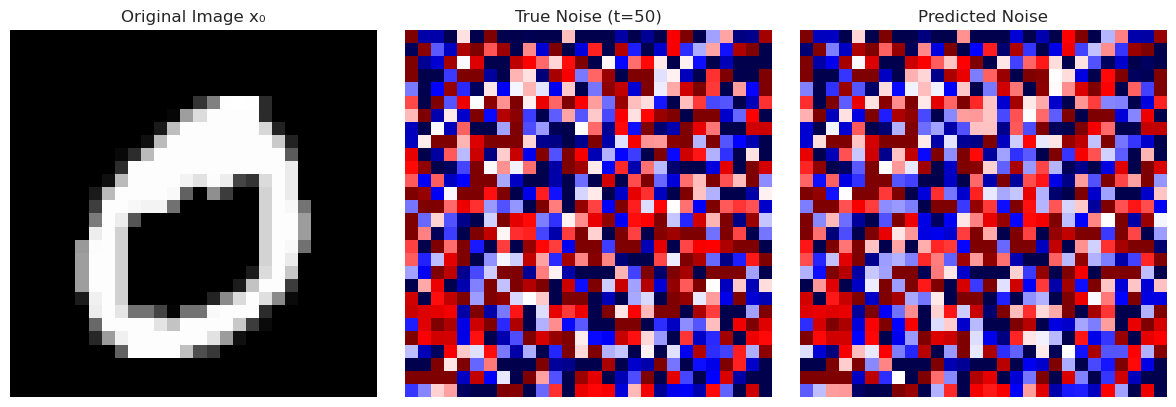

In [47]:
# x_test, _ = next(iter(train_loader))
# x0 = x_test[0:1]  # [1, 1, 28, 28]
plot_predicted_vs_true_noise(model, x0, t_step=50)

In [48]:
@torch.no_grad()
def sample_from_diffusion(model, num_samples=16, steps=diffusion_steps):
    model.eval()
    shape = (num_samples, 1, 28, 28)
    x_t = torch.randn(shape).to(device)  # 初始为纯噪声

    for t in reversed(range(1, steps)):
        t_tensor = torch.full((num_samples,), t, device=device)
        pred_noise = model(x_t, t_tensor)

        alpha = alphas[t]
        alpha_bar = baralphas[t]
        beta = betas[t]

        # DDPM论文中的反向公式：
        x_t = (1 / torch.sqrt(alpha)) * (
            x_t - ((1 - alpha) / torch.sqrt(1 - alpha_bar)) * pred_noise
        )

        # 添加噪声（除最后一步外）
        if t > 1:
            noise = torch.randn_like(x_t)
            x_t += torch.sqrt(beta) * noise

    return x_t

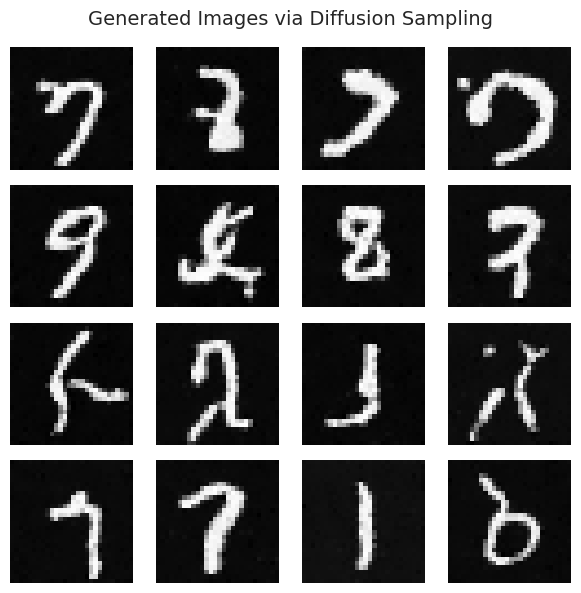

In [49]:
generated_imgs = sample_from_diffusion(model, num_samples=16)

fig, axes = plt.subplots(4, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_imgs[i].squeeze().cpu(), cmap="gray")
    ax.axis("off")
plt.suptitle("Generated Images via Diffusion Sampling", fontsize=14)
plt.tight_layout()
plt.show()


## Deep Ensembles

### Train multiple models with different random seeds.

In [24]:
num_models = 5
ensemble_models = []

for i in range(num_models):
    torch.manual_seed(i)

    # model = MNISTDiffusionCNN().to(device)
    model = MNISTUNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    # 每个模型重新初始化训练
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, _ in train_loader:
            x = x.to(device)
            t = torch.randint(0, diffusion_steps, (x.size(0),), device=device)
            noised_x, noise = q_sample(x, t)
            pred_noise = model(noised_x, t)
            loss = loss_fn(pred_noise, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Model {i}, Epoch {epoch}, Loss: {total_loss / len(train_loader):.4f}")

    ensemble_models.append(model)


Model 0, Epoch 0, Loss: 0.1748
Model 0, Epoch 1, Loss: 0.0986
Model 0, Epoch 2, Loss: 0.0886
Model 0, Epoch 3, Loss: 0.0855
Model 0, Epoch 4, Loss: 0.0813
Model 0, Epoch 5, Loss: 0.0809
Model 0, Epoch 6, Loss: 0.0785
Model 0, Epoch 7, Loss: 0.0765
Model 0, Epoch 8, Loss: 0.0764
Model 0, Epoch 9, Loss: 0.0763
Model 1, Epoch 0, Loss: 0.1709
Model 1, Epoch 1, Loss: 0.0952
Model 1, Epoch 2, Loss: 0.0871
Model 1, Epoch 3, Loss: 0.0829
Model 1, Epoch 4, Loss: 0.0809
Model 1, Epoch 5, Loss: 0.0788
Model 1, Epoch 6, Loss: 0.0772
Model 1, Epoch 7, Loss: 0.0765
Model 1, Epoch 8, Loss: 0.0752
Model 1, Epoch 9, Loss: 0.0751
Model 2, Epoch 0, Loss: 0.1691
Model 2, Epoch 1, Loss: 0.0967
Model 2, Epoch 2, Loss: 0.0882
Model 2, Epoch 3, Loss: 0.0842
Model 2, Epoch 4, Loss: 0.0810
Model 2, Epoch 5, Loss: 0.0796
Model 2, Epoch 6, Loss: 0.0777
Model 2, Epoch 7, Loss: 0.0778
Model 2, Epoch 8, Loss: 0.0767
Model 2, Epoch 9, Loss: 0.0759
Model 3, Epoch 0, Loss: 0.1698
Model 3, Epoch 1, Loss: 0.0952
Model 3,

In [25]:
def predict_with_ensemble(models, x, t):
    preds = torch.stack([m(x, t) for m in models])  # shape: [n_models, B, 1, 28, 28]
    mean = preds.mean(0)
    std = preds.std(0)
    return mean, std


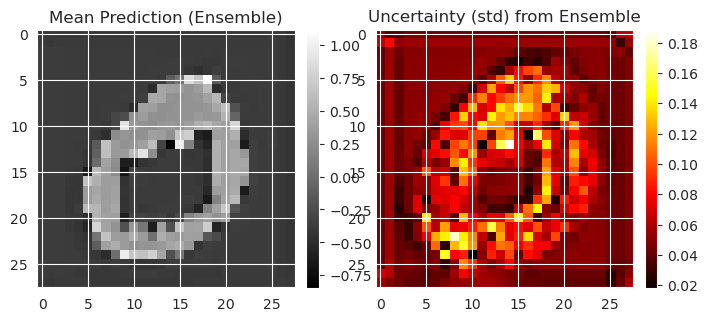

In [26]:
x_test = x_test[:16].to(device)
t_test = torch.full((x_test.size(0),), 50, device=device)
de_mean_pred, de_std_pred = predict_with_ensemble(ensemble_models, x_test, t_test)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

image0 = axes[0].imshow(de_mean_pred[0].squeeze().cpu().detach(), cmap="gray")
axes[0].set_title("Mean Prediction (Ensemble)")
plt.colorbar(image0, ax=axes[0], fraction=0.046, pad=0.04)

image1 = axes[1].imshow(de_std_pred[0].squeeze().cpu().detach(), cmap="hot")
axes[1].set_title("Uncertainty (std) from Ensemble")
plt.colorbar(image1, ax=axes[1], fraction=0.046, pad=0.04)

plt.show()


In [27]:
metrics = analyze_uncertainty(de_std_pred, mean_pred=de_mean_pred)

for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

uncertainty_mean: 0.0688
uncertainty_std: 0.0296
uncertainty_max: 0.2653
uncertainty_min: 0.0073
high_uncertainty_ratio: 0.1857
